In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from scipy.signal import dfreqresp
from sklearn.model_selection import train_test_split
from visualize_clf import visualize_clf
# from plot3d import plot3d
# from prepare import prepare_data

params = {'xtick.labelsize': 18,
'ytick.labelsize': 18,
'axes.titlesize' : 22,
'axes.labelsize' : 20,
'legend.fontsize': 18,
'legend.title_fontsize': 22,
'figure.titlesize': 24 }
pylab.rcParams.update(params)

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from verify_gradients import numerical_subgradient, compare_gradients
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


## Preliminary: Data Loading

In [3]:
df_train = pd.read_csv("train_prepared.csv")
df_test = pd.read_csv("test_prepared.csv")


## Part 1: Basic model selection with k-Nearest Neighbors

In [4]:
x_train = df_train[['PCR_01', 'PCR_08']].to_numpy()
y_train = df_train['spread']

x_test = df_test[['PCR_01', 'PCR_08']].to_numpy()
y_test = df_test['spread']

#### Visualization and basic analysis


Q1

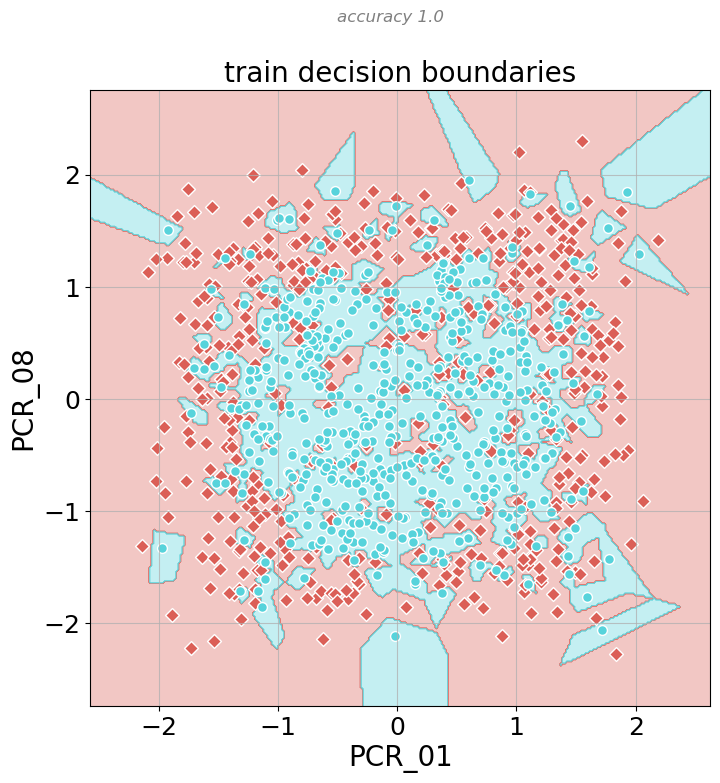

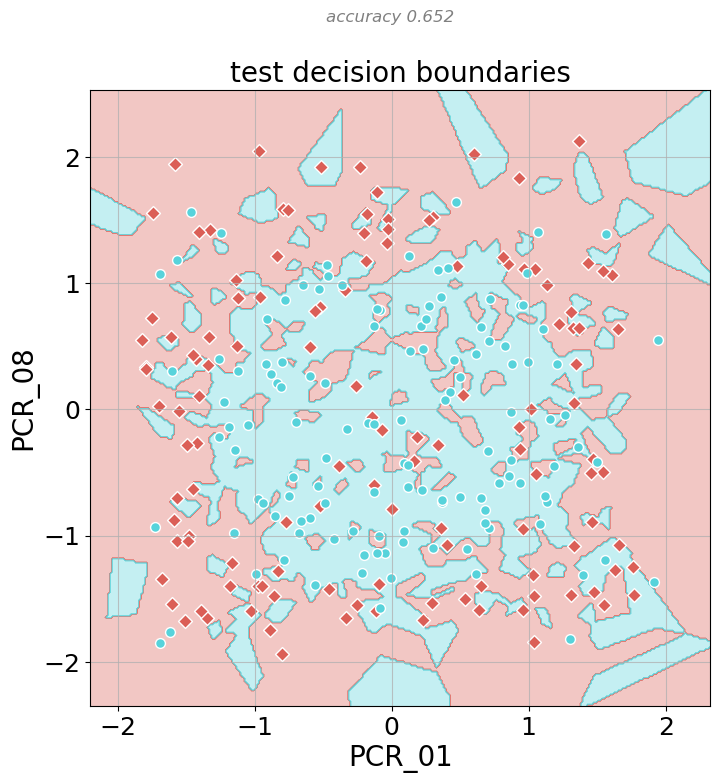

In [5]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train,y_train)

text =f'accuracy {knn.score(x_train, y_train)}' 
visualize_clf(knn,x_train,y_train, title= 'train decision boundaries',xlabel= 'PCR_01',ylabel= 'PCR_08', text= text)

text =f'accuracy {knn.score(x_test, y_test)}' 
visualize_clf(knn,x_test,y_test, title= 'test decision boundaries',xlabel= 'PCR_01',ylabel= 'PCR_08', text= text)

#### Model selection

Q2

In [6]:
k_vals = list(range(1, 20, 2)) + list(range(20, 695, 65))
train_scores =[]
validation_scores = []
max_score = dict(k=0,train_score=0, max_validation_score=0)

for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors= k)

    result = cross_validate(knn, x_train, y_train, cv= 8, return_train_score= True)
    train_score = np.mean(result['train_score'])
    validation_score = np.mean(result['test_score'])

    train_scores.append(train_score)
    validation_scores.append(validation_score)

    if validation_score > max_score['max_validation_score']:
        max_score['k'] = k
        max_score['train_score'] = train_score
        max_score['max_validation_score'] = validation_score


print (max_score)



    



{'k': 15, 'train_score': 0.804, 'max_validation_score': 0.792}


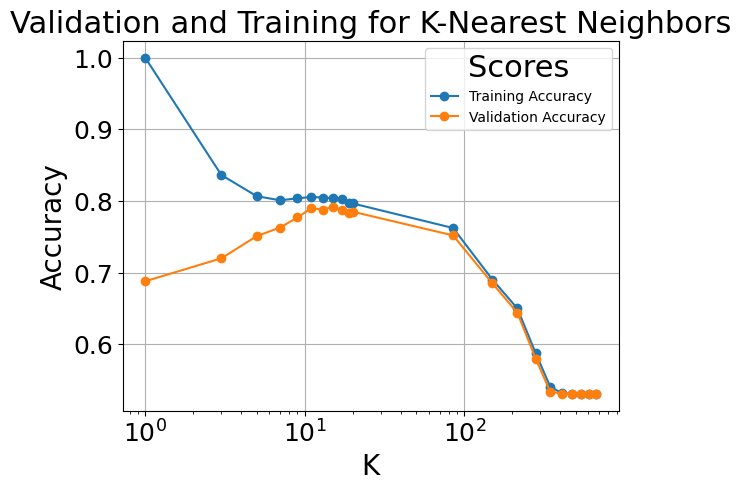

In [7]:
plt.semilogx(k_vals, train_scores, label='Training Accuracy', marker='o')
plt.semilogx(k_vals, validation_scores, label='Validation Accuracy', marker='o')

# for i, k in enumerate(k_vals):
#     plt.annotate(f"{k}", (k_vals[i], train_scores[i]), textcoords="offset points", xytext=(-10, 5), fontsize=9, color='blue')
#     plt.annotate(f"{k}", (k_vals[i], validation_scores[i]), textcoords="offset points", xytext=(-10, -10), fontsize=9, color='orange')


plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Validation and Training for K-Nearest Neighbors')

plt.grid(True)

plt.legend(fontsize=10, title='Scores')

plt.show()

Q3

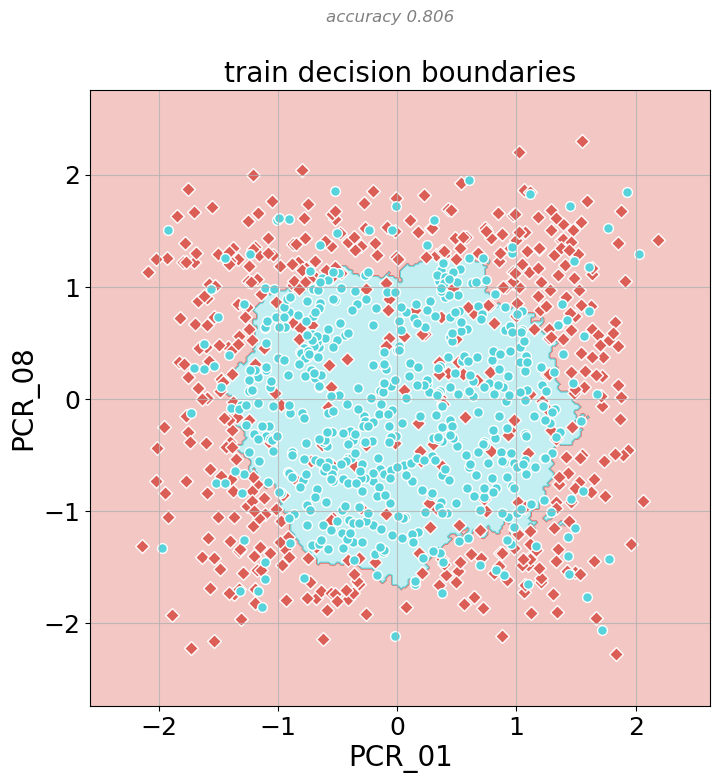

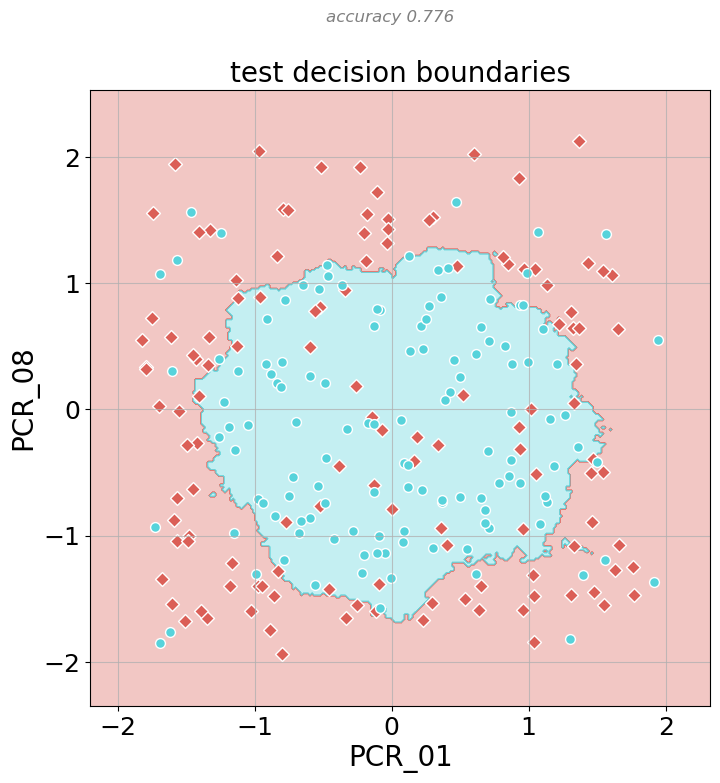

In [8]:

knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(x_train,y_train)

text =f'accuracy {knn.score(x_train, y_train)}' 
visualize_clf(knn,x_train,y_train, title= 'train decision boundaries',xlabel= 'PCR_01',ylabel= 'PCR_08', text= text)

text =f'accuracy {knn.score(x_test, y_test)}' 
visualize_clf(knn,x_test,y_test, title= 'test decision boundaries',xlabel= 'PCR_01',ylabel= 'PCR_08', text= text)

## Part 2: Decision trees

In [9]:
x_train = df_train[['PCR_04', 'PCR_06', 'blood_type_group']]
y_train = df_train['risk']

x_test = df_test[['PCR_04', 'PCR_06', 'blood_type_group']]
y_test = df_test['risk']


#### Visualization

Q5

In [10]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3)

tree.fit(x_train,y_train)

score = tree.score(x_train, y_train)
print(f'train accuracy: {score}')


train accuracy: 0.691


[Text(0.5, 0.875, 'blood_type_group <= 0.5\nentropy = 1.0\nsamples = 1000\nvalue = [489, 511]\nclass = high risk'),
 Text(0.25, 0.625, 'PCR_04 <= 0.199\nentropy = 0.933\nsamples = 508\nvalue = [177, 331]\nclass = high risk'),
 Text(0.125, 0.375, 'PCR_04 <= -0.554\nentropy = 0.999\nsamples = 315\nvalue = [152, 163]\nclass = high risk'),
 Text(0.0625, 0.125, 'entropy = 0.644\nsamples = 67\nvalue = [11, 56]\nclass = high risk'),
 Text(0.1875, 0.125, 'entropy = 0.986\nsamples = 248\nvalue = [141, 107]\nclass = low risk'),
 Text(0.375, 0.375, 'PCR_06 <= 0.214\nentropy = 0.556\nsamples = 193\nvalue = [25, 168]\nclass = high risk'),
 Text(0.3125, 0.125, 'entropy = 0.762\nsamples = 113\nvalue = [25, 88]\nclass = high risk'),
 Text(0.4375, 0.125, 'entropy = 0.0\nsamples = 80\nvalue = [0, 80]\nclass = high risk'),
 Text(0.75, 0.625, 'PCR_06 <= 0.444\nentropy = 0.947\nsamples = 492\nvalue = [312, 180]\nclass = low risk'),
 Text(0.625, 0.375, 'PCR_04 <= -0.419\nentropy = 0.989\nsamples = 403\nvalu

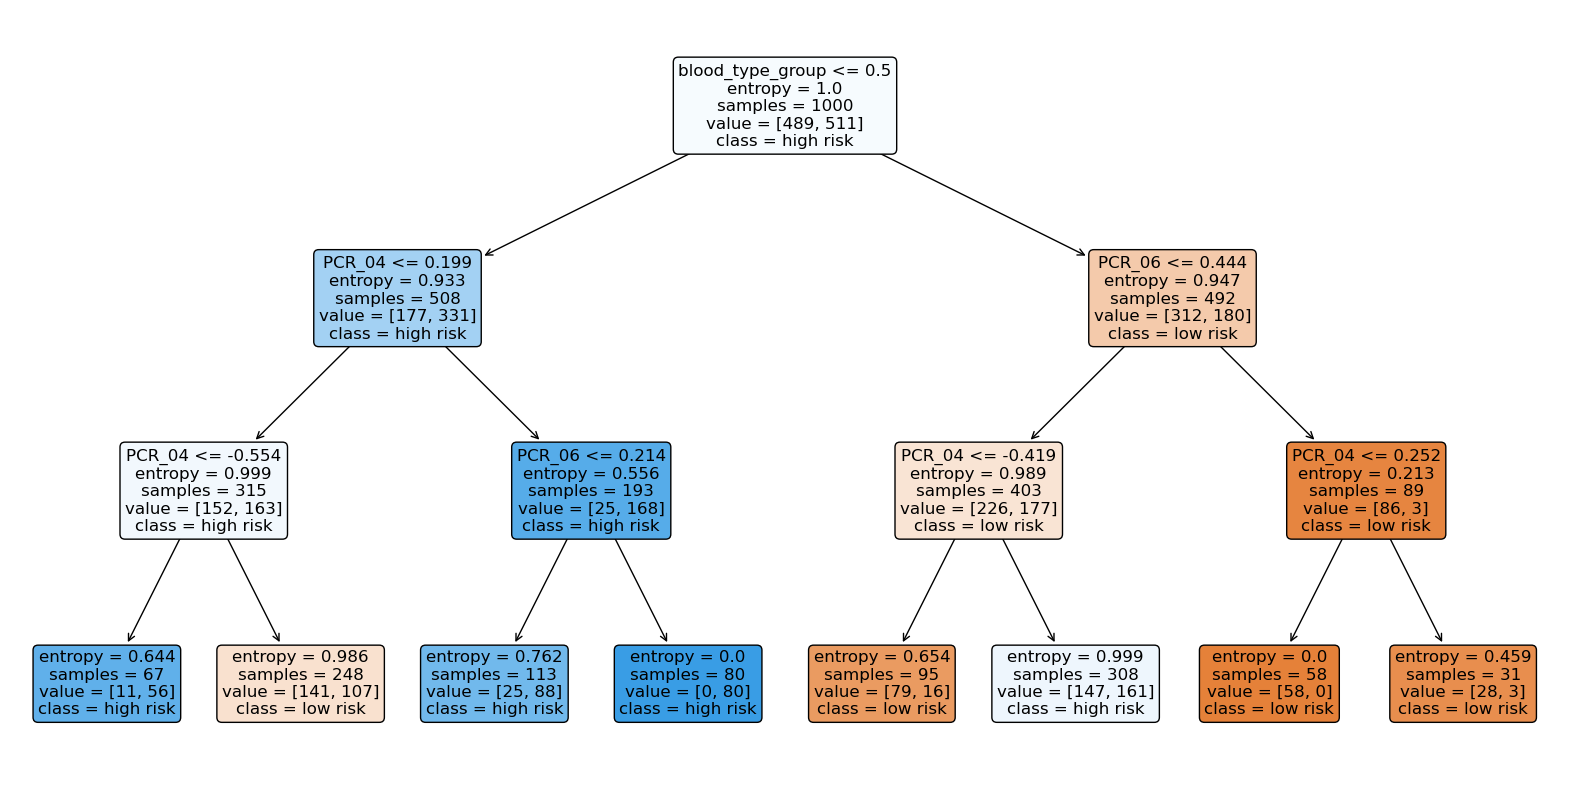

In [11]:

plt.figure(figsize=(20, 10))

plot_tree(tree, feature_names=['PCR_04', 'PCR_06', 'blood_type_group'], class_names=['low risk', 'high risk'], filled=True,rounded=True, fontsize=12)

#### Model selection


Q6

In [12]:
min_samples_range = range(2, 20, 1)
max_depth_range = range(1, 20, 1)
params = {'min_samples_split': min_samples_range, 'max_depth': max_depth_range}

tree = DecisionTreeClassifier(criterion='entropy')

grid_search = GridSearchCV(tree, param_grid=params, cv=5, return_train_score=True)


In [13]:
grid_search.fit(x_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)

In [14]:
grid_search.best_score_
print(f'best score: {grid_search.best_score_} with params: {grid_search.best_params_}')

best score: 0.787 with params: {'max_depth': 8, 'min_samples_split': 18}


Text(0.5, 1.0, 'mean_test_score')

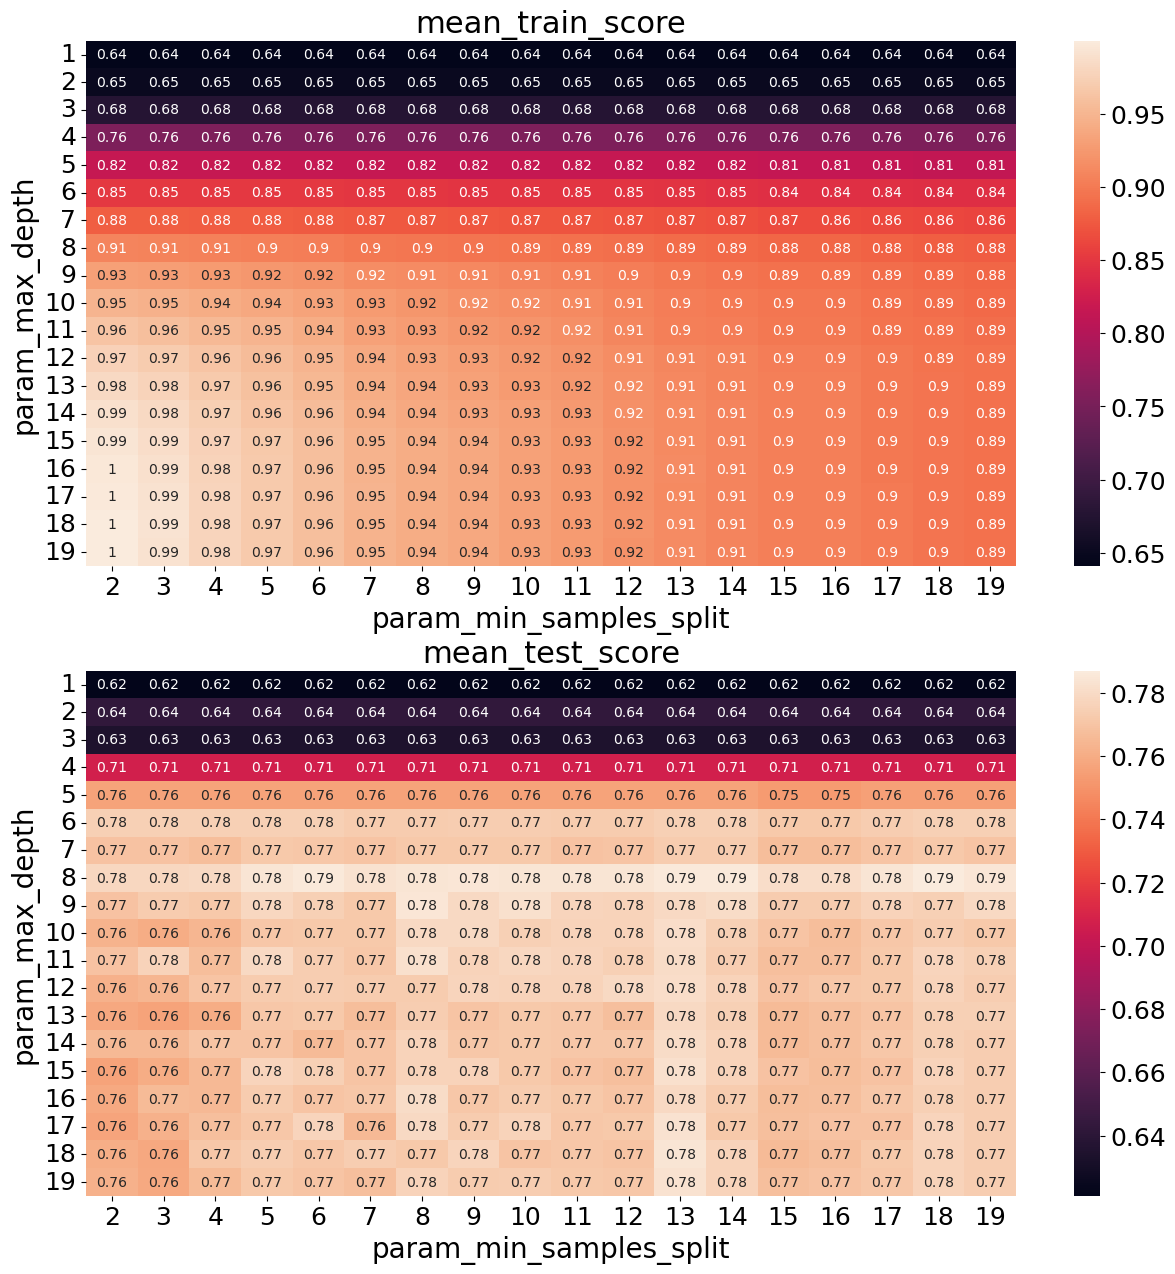

In [15]:
train_data = results[['param_max_depth', 'param_min_samples_split', 'mean_train_score']]
validation_data = results[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]

fig, axes = plt.subplots(2, 1, figsize=(15, 15)) 

sns.heatmap(train_data.pivot(index= 'param_max_depth',columns= 'param_min_samples_split',values= 'mean_train_score'), annot=True , ax=axes[0])
axes[0].set_title('mean_train_score')

sns.heatmap(validation_data.pivot(index= 'param_max_depth',columns= 'param_min_samples_split',values= 'mean_test_score'), annot=True, ax=axes[1])
axes[1].set_title('mean_test_score')

Q8

In [16]:
tree = grid_search.best_estimator_

tree.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=18)

In [17]:
tree.score(x_test, y_test)

0.764

## Part 3: Linear SVM and the Polynomial kernel


In [18]:
x_train = df_train[['PCR_01', 'PCR_08']].to_numpy()
y_train = df_train['spread'].to_numpy()

x_test = df_test[['PCR_01', 'PCR_08']].to_numpy()
y_test = df_test['spread'].to_numpy()

#### Implementation of the loss and its gradient


In [19]:
from SoftSVM import SoftSVM

#### Verifying your implementation: Numerical vs. analytical gradients


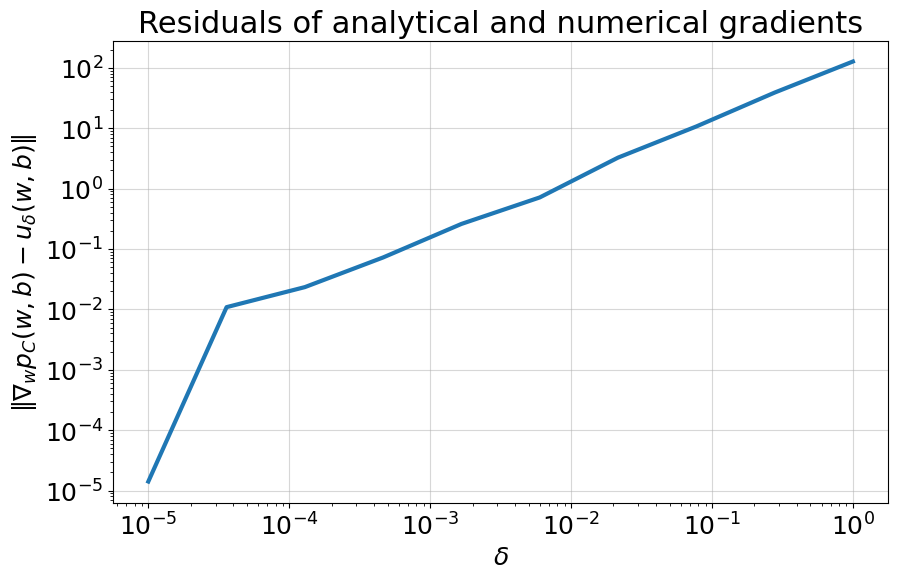

In [20]:
compare_gradients(x_train, y_train, deltas=np.logspace(-5, 0, 10))

#### Solving Soft SVM problems using Stochastic Gradient Descent (SGD)


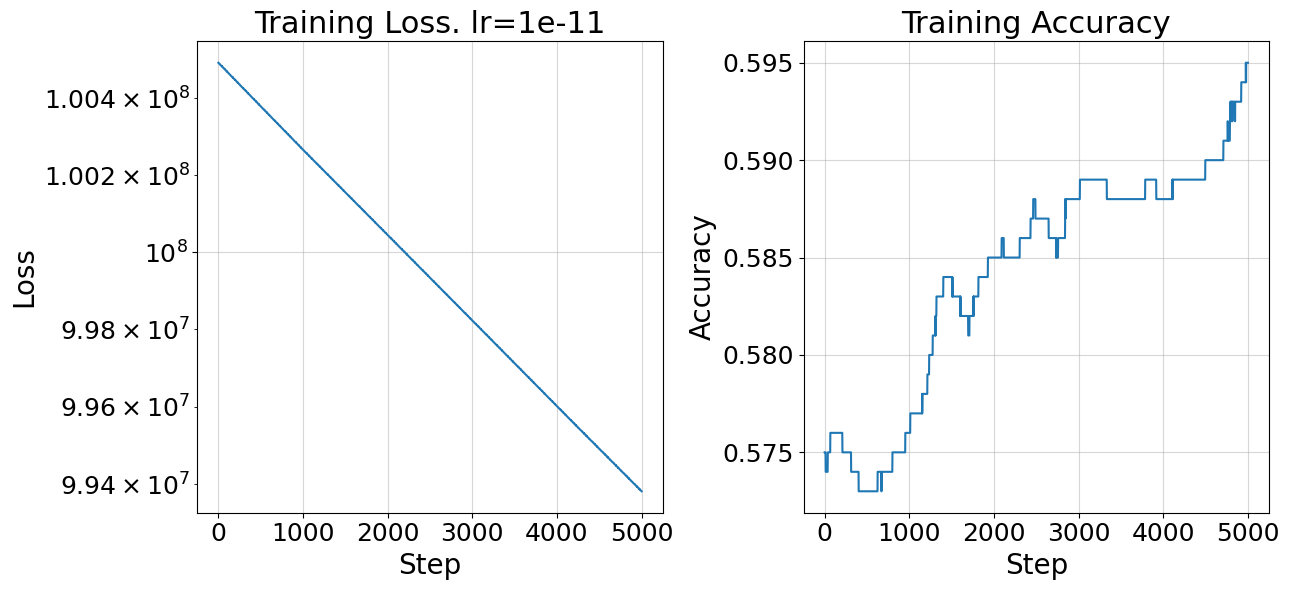

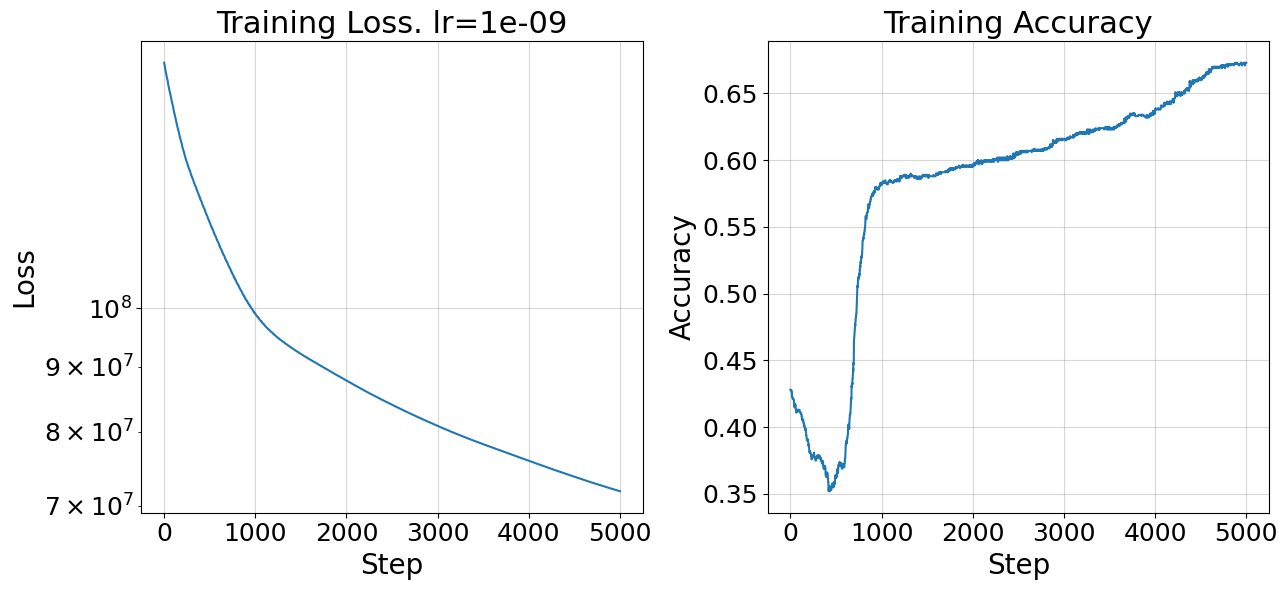

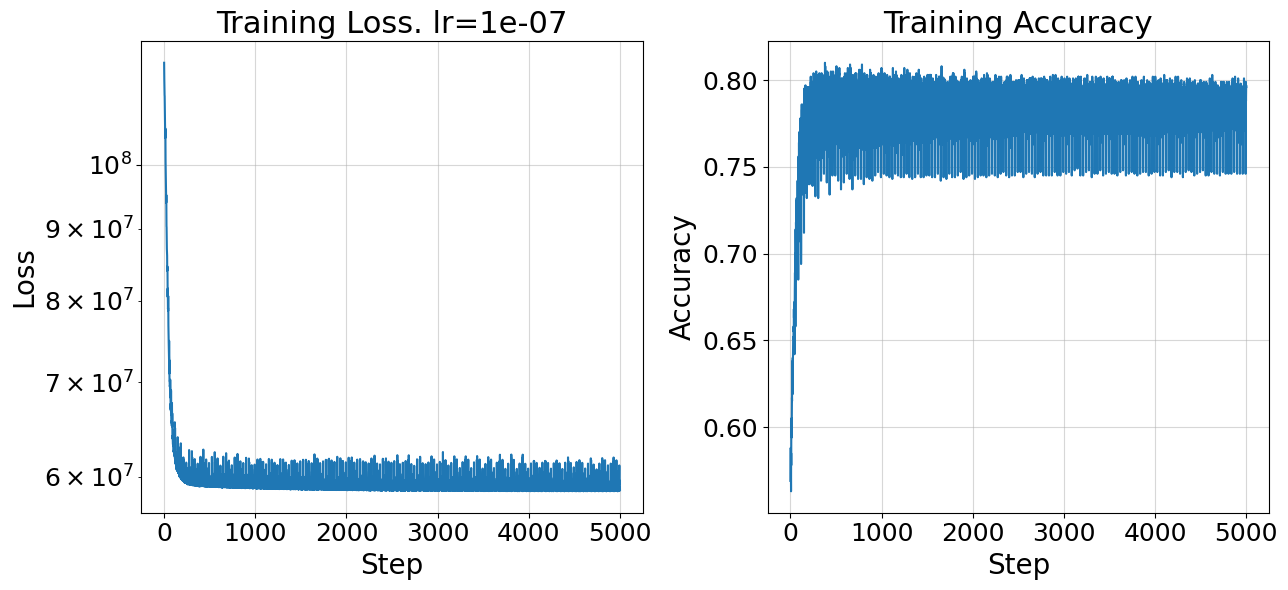

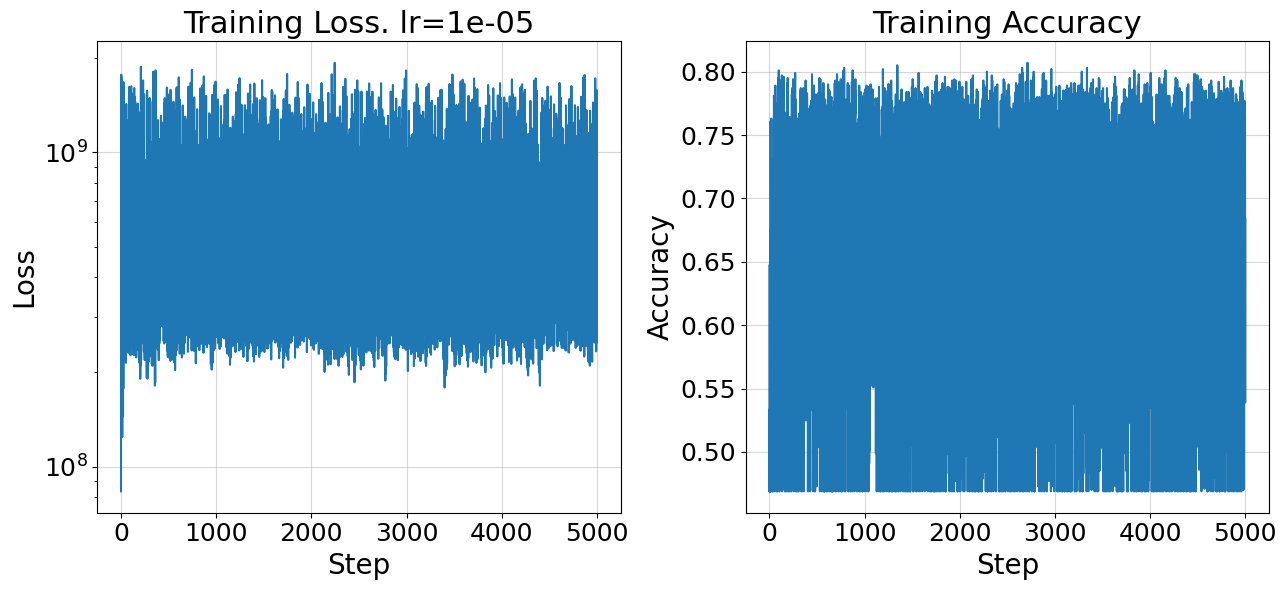

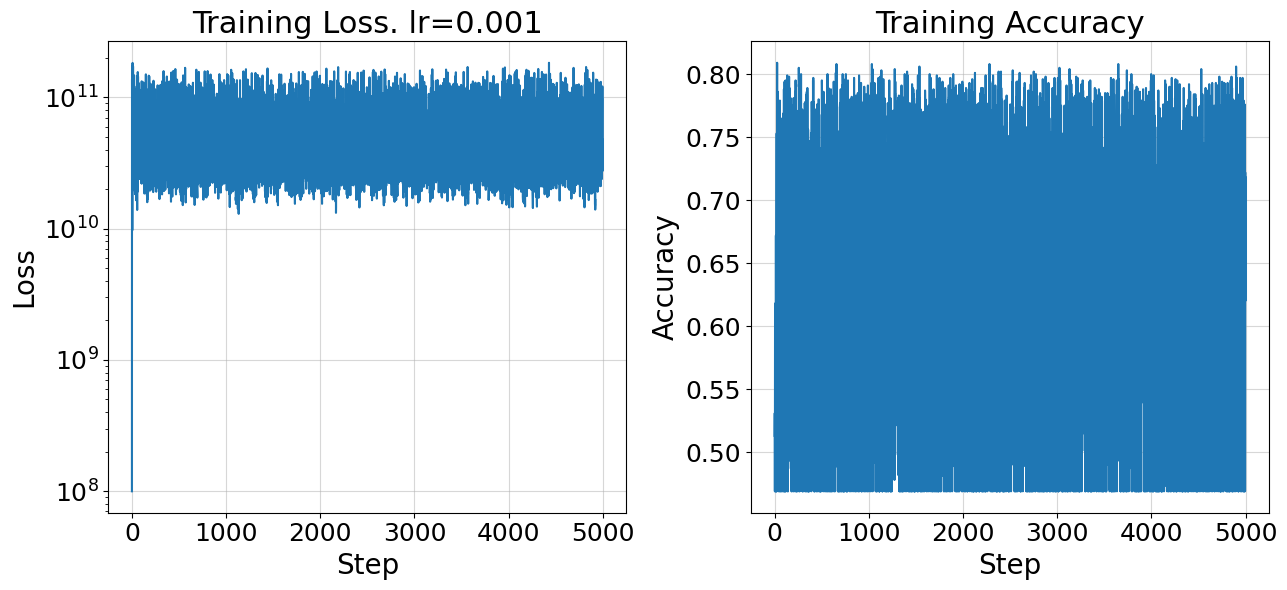

In [21]:
for lr in np.logspace(-11, -3, 5):
    C=1e5
    clf = SoftSVM(C=C, lr=lr)
    X_train_poly = PolynomialFeatures(degree=3,).fit_transform(x_train)
    X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
    losses, accuracies = clf.fit_with_logs(X_train_poly, y_train, max_iter=5000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title (f"Training Loss. lr={lr}")
    plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy")
    plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

#### Using a feature mapping


In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=3)),
    ('scaler', MinMaxScaler()),
    ('SVM', SoftSVM(C=1e5, lr=1e-7))])
svm_clf.fit(x_train, y_train)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('scaler', MinMaxScaler()),
                ('SVM', SoftSVM(C=100000.0, lr=1e-07))])

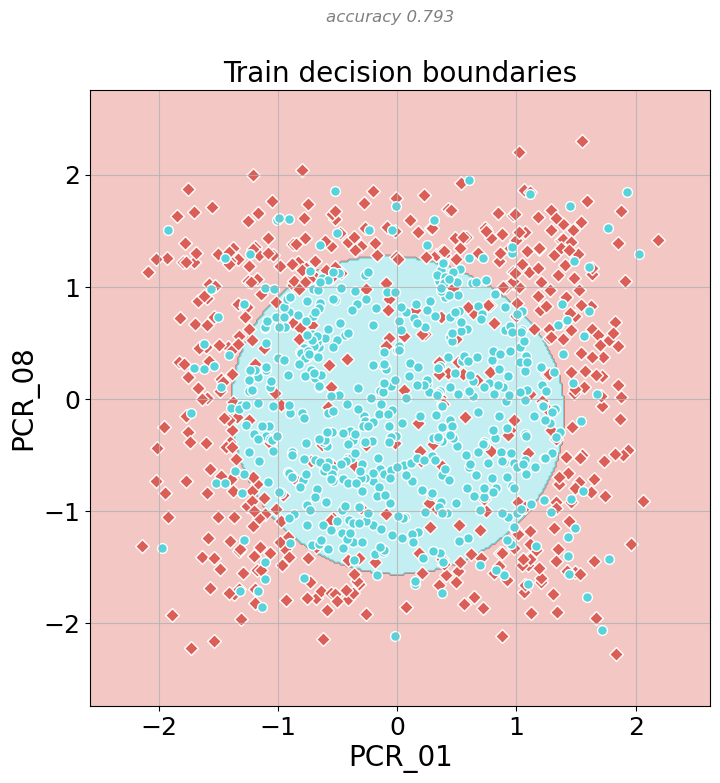

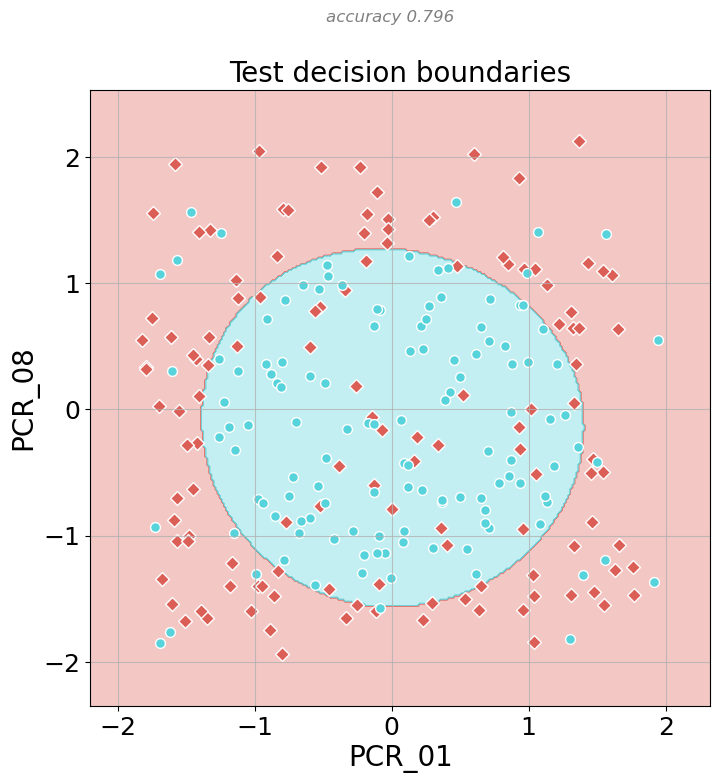

In [23]:
text = f'accuracy {svm_clf.score(x_train, y_train)}'
visualize_clf(svm_clf, x_train, y_train, title='Train decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

text = f'accuracy {svm_clf.score(x_test, y_test)}'
visualize_clf(svm_clf, x_test, y_test, title='Test decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

## Part 4: The RBF kernel

In [24]:
from sklearn.svm import SVC

In [25]:
svm_clf = SVC(kernel='rbf', C=1, gamma=1e-7)
svm_clf.fit(x_train, y_train)

SVC(C=1, gamma=1e-07)

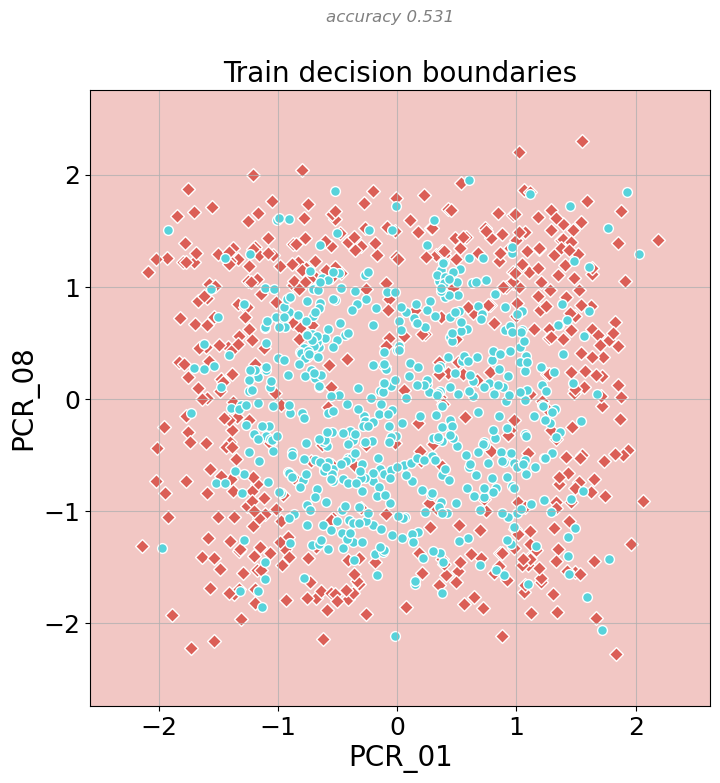

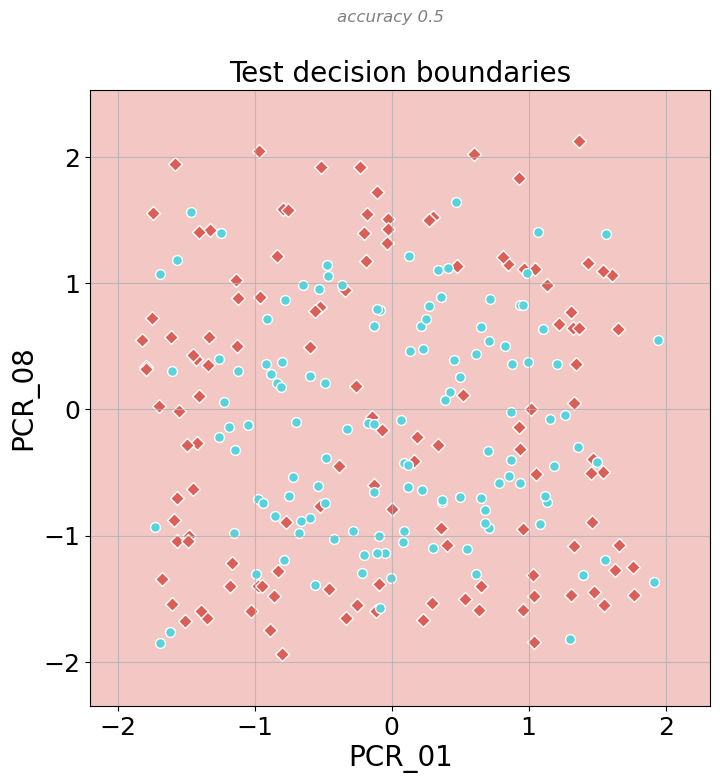

In [26]:

text = f'accuracy {svm_clf.score(x_train, y_train)}'
visualize_clf(svm_clf, x_train, y_train, title='Train decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

text = f'accuracy {svm_clf.score(x_test, y_test)}'
visualize_clf(svm_clf, x_test, y_test, title='Test decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

In [27]:

svm_clf = SVC(kernel='rbf', C=1, gamma=200)
svm_clf.fit(x_train, y_train)

SVC(C=1, gamma=200)

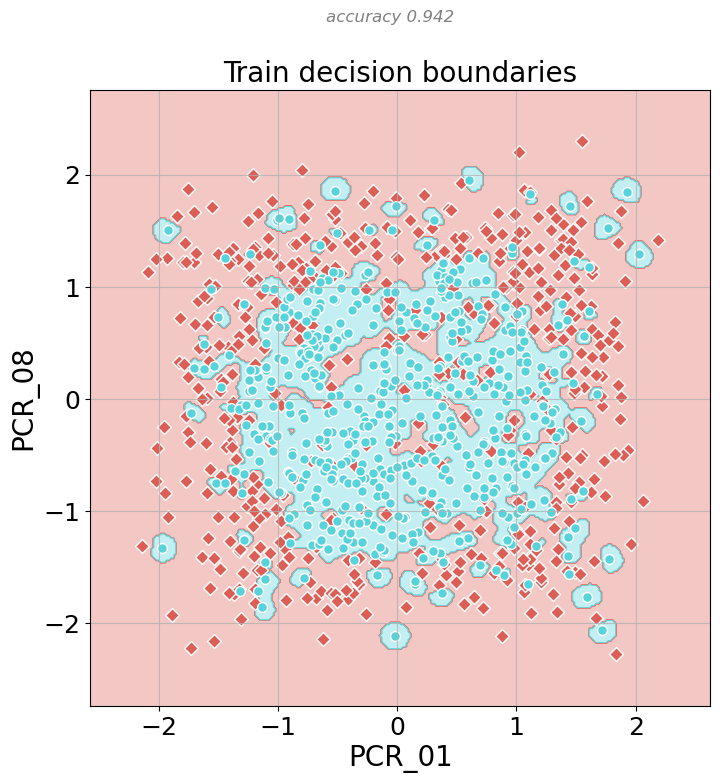

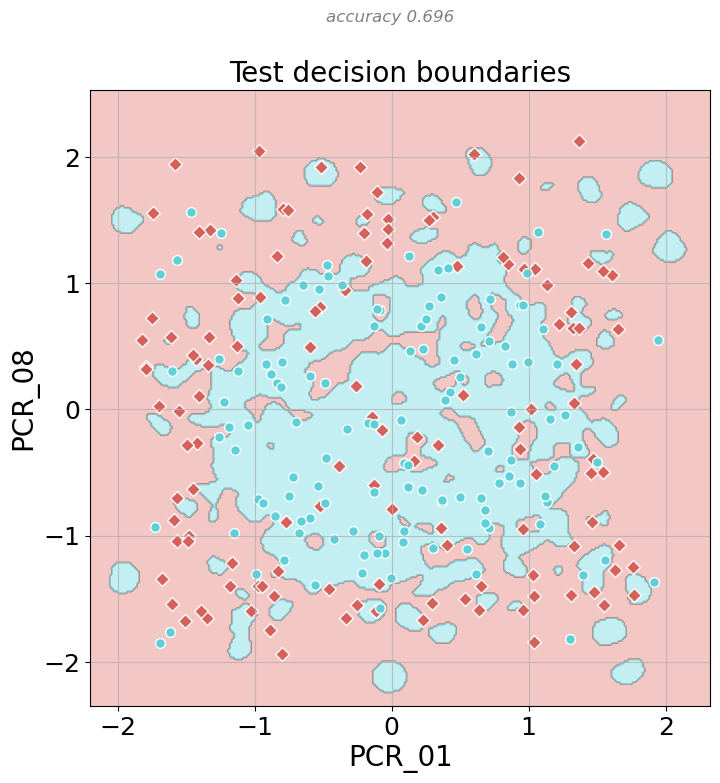

In [28]:

text = f'accuracy {svm_clf.score(x_train, y_train)}'
visualize_clf(svm_clf, x_train, y_train, title='Train decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

text = f'accuracy {svm_clf.score(x_test, y_test)}'
visualize_clf(svm_clf, x_test, y_test, title='Test decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

In [29]:

svm_clf = SVC(kernel='rbf', C=1, gamma= 5000)
svm_clf.fit(x_train, y_train)

SVC(C=1, gamma=5000)

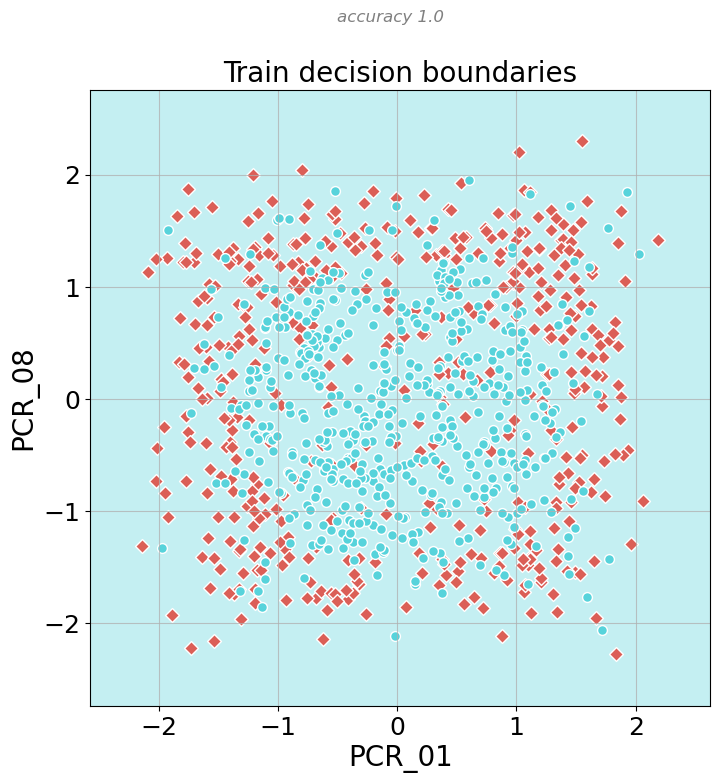

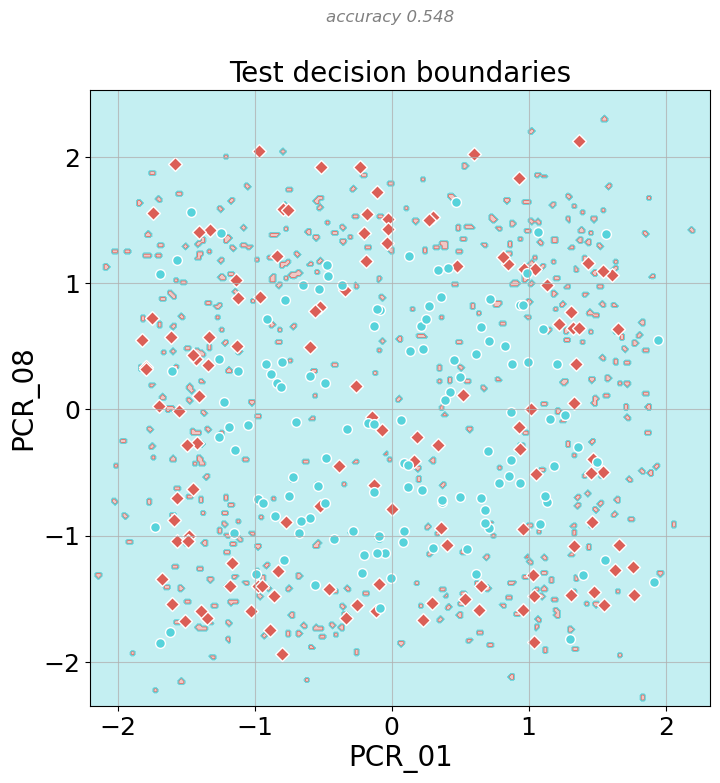

In [30]:

text = f'accuracy {svm_clf.score(x_train, y_train)}'
visualize_clf(svm_clf, x_train, y_train, title='Train decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)

text = f'accuracy {svm_clf.score(x_test, y_test)}'
visualize_clf(svm_clf, x_test, y_test, title='Test decision boundaries', xlabel='PCR_01', ylabel='PCR_08', text=text)